In [1]:
from src import utility_functions, clustering, training
# import importlib
# importlib.reload(utility_functions)
# import clustering
# importlib.reload(clustering)
# import training
# importlib.reload(training)

import shutil
import json
# import mxnet as mx
import numpy as np
import tensorflow as tf
import os
from os.path import join
from numpy.random import seed
from numpy import unique, where, savez_compressed
import random
import torch
import re
import keras
from tqdm import tqdm
from sklearn.utils.extmath import softmax
from datetime import datetime
import pickle
import itertools
from sklearn.metrics import roc_curve

# # very important
# # ! git clone https://github.com/yinguobing/arcface.git
from scipy.spatial.distance import cdist
from sklearn import metrics

seed(1)
tf.random.set_seed(2)

# from src.torrent_downloader import download_torrent_or_magnet

In [2]:
# Load the configuration file
with open("./config/config.json", "r") as config_file:
    config = json.load(config_file)

In [3]:
# # download glint360k dataset
# glint360k_magnet_link = config["glint360k"]["magnet_link"] 
# glint360k_torrent_path = config["glint360k"]["torrent_path"] 
# glint360k_save_path = config["glint360k"]["orig_dataset_dir"]

# # try:
# #     download_torrent_or_magnet(glint360k_torrent_path, glint360k_save_path)
# # except:
# #     download_torrent_or_magnet(glint360k_magnet_link, glint360k_save_path)

# # download ms1m dataset
# ms1m_torrent_path = config["ms-celeb-1m"]["torrent_path"] 
# ms1m_save_path = config["ms-celeb-1m"]["orig_dataset_dir"]

# # download_torrent_or_magnet(ms1m_torrent_path, ms1m_save_path)

# # download vggface2 dataset
# vggface2_torrent_path = config["vggface2"]["magnet_link"]
# vggface2_save_path = config["vggface2"]["orig_dataset_dir"]

# # download_torrent_or_magnet(vggface2_torrent_path, vggface2_save_path)

# prepare data such that each id has 20 images for train, 5 for test and 5 for validation (for all datasets)
# balanced datasets are balanced_glint360k, balanced_ms1m, balanced_vggface2

# extract features of all images using onnx pretrained model and save them in dataset_name/embeddings directory

In [4]:
def prepare_data(dataset_name):
    train_embeddings_path = join(config[dataset_name]["features"], 'train')
    val_embeddings_path = join(config[dataset_name]["features"], 'val')
    test_embeddings_path = join(config[dataset_name]["features"], 'test')

    trainx = []
    trainy = []
    trainl = []

    traincenterx = []
    traincentery = []
    traincenterl = []

    testx = []
    testy = []
    testl = []

    valx = []
    valy = []
    vall = []

    if overwrite == False and os.path.isfile(join(super_scenario_path, 'testx.npz')):
        trainx = np.load(join(super_scenario_path, 'trainx.npz'))['res']
        trainy = np.load(join(super_scenario_path, 'trainy.npz'))['res']
        trainl = np.load(join(super_scenario_path, 'trainl.npz'))['res']

        traincenterx = np.load(join(super_scenario_path, 'traincenterx.npz'))['res']
        traincentery = np.load(join(super_scenario_path, 'traincentery.npz'))['res']
        traincenterl = np.load(join(super_scenario_path, 'traincenterl.npz'))['res']

        testx = np.load(join(super_scenario_path, 'testx.npz'))['res']
        testy = np.load(join(super_scenario_path, 'testy.npz'))['res']
        testl = np.load(join(super_scenario_path, 'testl.npz'))['res']

        valx = np.load(join(super_scenario_path, 'valx.npz'))['res']
        valy = np.load(join(super_scenario_path, 'valy.npz'))['res']
        vall = np.load(join(super_scenario_path, 'vall.npz'))['res']
    else:
        all_id_files = dict()
        with open(join(config[dataset_name]['orig_dataset_dir'], dataset_name, 'all_id_files.json')) as jsonfile:
            all_id_files = json.load(jsonfile)

        keys = list(all_id_files.keys())[:n_classes]
        
        os.makedirs(join('..', dataset_name, 'data', str(n_classes)), exist_ok=True)

        idx = 0
        for class_name in tqdm(keys):
            tr_x = np.load(join(train_embeddings_path, class_name + '.npz'), allow_pickle=True)
            tr_f = 20 # len(tr_features)
            tr_features = tr_x[tr_x.files[0]][:tr_f]    
            trainx.extend(tr_features)
            trainy.extend([class_name] for t in range(tr_f))
            trainl.extend([idx] for t in range(tr_f))

            traincenterx.append(np.mean(tr_features, axis=0))
            traincenterl.append(idx)
            traincentery.append(class_name)

            te_x = np.load(join(test_embeddings_path, class_name + '.npz'), allow_pickle=True)
            te_f = 5 # len(te_features)
            te_features = te_x[te_x.files[0]][:te_f]
            testx.extend(te_features)
            testl.extend([idx] for t in range(te_f))
            testy.extend([class_name] for t in range(te_f))

            v_x = np.load(join(val_embeddings_path, class_name + '.npz'), allow_pickle=True)
            v_f = 5 # len(v_features)
            v_features = v_x[v_x.files[0]][:v_f]
            valx.extend(v_features)
            vall.extend([idx] for t in range(v_f))
            valy.extend([class_name] for t in range(v_f))

            idx+=1

        trainx = np.array(trainx)
        trainl = np.array(trainl)
        trainy = np.array(trainy)

        traincenterx = np.array(traincenterx)
        traincenterl = np.array(traincenterl)
        traincentery = np.array(traincentery)

        testx = np.array(testx)
        testl = np.array(testl)
        testy = np.array(testy)

        valx = np.array(valx)
        vall = np.array(vall)
        valy = np.array(valy)

        # TODO: remove later
        trainl = trainl.squeeze()
        testl = testl.squeeze()
        vall = vall.squeeze()
        trainy = trainy.squeeze()
        testy = testy.squeeze()
        valy = valy.squeeze()

        savez_compressed(join(super_scenario_path, 'trainx.npz'), res=trainx)
        savez_compressed(join(super_scenario_path, 'trainy.npz'), res=trainy)
        savez_compressed(join(super_scenario_path, 'trainl.npz'), res=trainl)

        savez_compressed(join(super_scenario_path, 'traincenterx.npz'), res=traincenterx)
        savez_compressed(join(super_scenario_path, 'traincentery.npz'), res=traincentery)
        savez_compressed(join(super_scenario_path, 'traincenterl.npz'), res=traincenterl)

        savez_compressed(join(super_scenario_path, 'testx.npz'), res=testx)
        savez_compressed(join(super_scenario_path, 'testy.npz'), res=testy)
        savez_compressed(join(super_scenario_path, 'testl.npz'), res=testl)

        savez_compressed(join(super_scenario_path, 'valx.npz'), res=valx)
        savez_compressed(join(super_scenario_path, 'valy.npz'), res=valy)
        savez_compressed(join(super_scenario_path, 'vall.npz'), res=vall)    

    return trainx, trainy, trainl, traincenterx, traincentery, traincenterl, testx, testy, testl, valx, valy, vall

In [5]:
def cluster_data(method, trainx, trainy, trainl, traincenterx, traincentery, traincenterl, testx, testy, testl, valx, valy, vall):
    distribution_path = join(data_scenario_path, 'parts.npz')
    parts = dict()

    if method == 'ISM':   
        if overwrite == False and os.path.isfile(distribution_path):
            parts = (np.load(distribution_path, allow_pickle=True)['res']).item()
        else:
            # # random 
            lbls = np.zeros((n_classes), dtype='int')
            for i in range(n_classes):
                lbls[i] = random.randint(0, n_clusters-1)
            for i in range(n_clusters):
                # parts[i] = torch.Tensor((lbls == i).nonzero()).squeeze(0).unsqueeze(1).cuda().int().cpu().numpy().squeeze(1)
                parts[i] = torch.Tensor((lbls == i).nonzero()).flatten().int().numpy()
            savez_compressed(distribution_path, res = parts)
    
    elif method == "MMS":
        clustering_model_filename = join(model_scenario_path, 'kmeans.sav')

        if overwrite == False and os.path.isfile(distribution_path) and os.path.isfile(clustering_model_filename):
            kmeans_model = pickle.load(open(clustering_model_filename, 'rb'))
            parts = (np.load(distribution_path, allow_pickle=True)['res']).item()
        else:
            centers, labels = clustering.init_centers(trainx, n_clusters) # IMPORTANT TODO: dont forget to cite the reference
            kmeans_model = clustering.Fast_KMeans(n_clusters=n_clusters, max_iter=100, tol=0.0001, verbose=0, centroids=centers, mode=m, minibatch=None)
            lbls = kmeans_model.fit_predict(torch.Tensor(traincenterx).cuda())
            pickle.dump(kmeans_model, open(clustering_model_filename, 'wb'))
            for i in range(n_clusters):
                parts[i] = (lbls == i).nonzero().cpu().numpy().squeeze(1)
            savez_compressed(distribution_path, res = parts)

    return parts

In [6]:
def train_submodels(method, parts, trainx, trainy, trainl, traincenterx, traincentery, traincenterl, testx, testy, testl, valx, valy, vall):
    dataset_path = config[dataset_name]["features"]
    for r in (range(n_clusters)):
        utility_functions.pprint(('cluster', str(r)), dataset_name)
        train_ids = utility_functions.train_calc_ids(parts[r], trainy, trainl, r)
        test_ids = utility_functions.test_calc_ids(parts[r], trainy, trainl, r)
        train_sample_count, test_sample_count = utility_functions.convert_emb_to_tfrecord(dataset_name, data_scenario_path, dataset_path, train_ids, test_ids, r, overwrite=False, all_samples=True, n_classes=len(parts[r]))
        train_dataset, test_dataset = utility_functions.prepare_data_sets(dataset_name, data_scenario_path, train_ids, test_ids, r)    
        training.softmax_train(dataset_name, model_scenario_path, train_dataset, parts[r], trainx, trainl, r, epochs=50,train_overwrite=False, freq = train_sample_count // 100)

In [7]:
def post_process(m, t = 'val'):
    models = dict()
    for idx in (range(n_clusters)):    
        model_path = join(model_scenario_path, str(idx), 'exported', 'hrnetv2')
        with tf.device('/cpu:0'):
            model = tf.keras.models.load_model(model_path)
            models[idx] = model

    model = None
    batch_softmax = None
    batch_argmax_softmax = None
    batch_max_softmax = None

    softmax_prediction = dict()
    batch_size = 1000

    batch_number = len(valx) // batch_size + (1 if (len(valx) % batch_size != 0) else 0)

    max_softmax = dict()
    argmax_softmax = dict()

    for idx in tqdm(range(n_clusters)):
        if overwrite == False and os.path.isfile(join(data_scenario_path, str(idx) + '_predicted_max.npz')) and os.path.isfile(join(data_scenario_path, str(idx) + '_predicted_argmax.npz')):
            max_softmax[idx] = np.load(join(data_scenario_path, str(idx) + '_' + t + '_predicted_max.npz'))['res']
            argmax_softmax[idx] = np.load(join(data_scenario_path, str(idx) + '_' + t + '_predicted_argmax.npz'))['res']
        else:
            model_path = join(model_scenario_path, str(idx), 'exported', 'hrnetv2')
            model = tf.keras.models.load_model(model_path)

            max_softmax[idx] = []
            argmax_softmax[idx] = []

            for batch_counter in range(batch_number):
                batch_softmax = model(np.array(valx[batch_counter * batch_size : np.min([len(valx), (batch_counter + 1) * batch_size])]))
                batch_max_softmax = np.max(batch_softmax, axis=1)
                batch_argmax_softmax = np.argmax(batch_softmax, axis=1)
                max_softmax[idx] += list(batch_max_softmax)
                argmax_softmax[idx] += list(batch_argmax_softmax)
            savez_compressed(join(data_scenario_path, str(idx) + '_' + t + '_predicted_max.npz'), res=max_softmax[idx])
            savez_compressed(join(data_scenario_path, str(idx) + '_' + t + '_predicted_argmax.npz'), res=argmax_softmax[idx])

    max_softmax = np.array(list(max_softmax.values())).transpose()
    argmax_softmax = np.array(list(argmax_softmax.values())).transpose()

    # ابتدا نزدیکترین دسته به هر نمونه آزمون را پیدا میکنیم
    # شماره دسته، شماره خوشه، شماره دسته در خوشه و مقدار شباهت کسینوسی و مقدار سافتمکس نزدیکترین دسته را در لیستهای مجزا ذخیره میکنیم
    batch_size = 5000
    batch_numbers = len(valx) // batch_size + (1 if (len(valx) % batch_size != 0) else 0)

    sim_clusters = []
    sim_classes = []
    sim_classes_in_clusters=[]
    sim_values = []

    pre_path = data_scenario_path

    if overwrite == False and os.path.isfile(join(pre_path, t + '_sim_clusters.pt')):
        sim_clusters = np.array(torch.load(join(pre_path, t + '_sim_clusters.pt')))
        sim_classes = np.array(torch.load(join(pre_path, t + '_sim_classes.pt')))
        sim_classes_in_clusters = np.array(torch.load(join(pre_path, t + '_sim_classes_in_clusters.pt')))
        sim_values = np.array(torch.load(join(pre_path, t + '_sim_values.pt')))
        sim_softmax = np.array(torch.load(join(pre_path, t + '_sim_softmax.pt')))
    else:
        for batch in tqdm(range(batch_numbers)):
            if batch == batch_numbers - 1 and (len(valx) % batch_size):
                batch_clusters = [0] * (len(valx) % batch_size)
            else:
                batch_clusters = [0] * batch_size
            batch_classes_in_clusters = []
            if m == 'euclidean':
                batch_sim = utility_functions.euc_sim(torch.Tensor(valx[batch*batch_size:np.min([len(valx), (batch+1)*batch_size])]), torch.Tensor(traincenterx)) 
            else:
                batch_sim = utility_functions.cos_sim(torch.Tensor(valx[batch*batch_size:np.min([len(valx), (batch+1)*batch_size])]), torch.Tensor(traincenterx))
            
            # just for euclidean
            if m == 'euclidean':
                v = batch_sim
                v_min, v_max = v.min(), v.max() #(dim=1)[0], v.max(dim=1)[0]
                new_min, new_max = 0, 0.9
                v_p = ((v.transpose(0,1) - v_min)/(v_max - v_min)*(new_max - new_min) + new_min).transpose(0,1)
                batch_sim = v_p

            batch_classes = (batch_sim.max(1)[1]).numpy()
            batch_values = (batch_sim.max(1)[0]).numpy()
            for r in parts:
                batch_clusters += (r * (np.in1d(batch_classes, parts[r])).astype(np.int32))
            for idx, b in enumerate(batch_classes):
                batch_classes_in_clusters.append(np.where(parts[batch_clusters[idx]] == batch_classes[idx].item())[0][0])
            
            sim_clusters.extend(list(batch_clusters))
            sim_classes.extend(list(batch_classes))
            sim_classes_in_clusters.extend(list(batch_classes_in_clusters))
            sim_values.extend(list(batch_values))

        torch.save(torch.Tensor(sim_clusters), join(pre_path, t + '_sim_clusters.pt'))
        torch.save(torch.Tensor(sim_classes), join(pre_path, t + '_sim_classes.pt'))
        torch.save(torch.Tensor(sim_classes_in_clusters), join(pre_path, t + '_sim_classes_in_clusters.pt'))
        torch.save(torch.Tensor(sim_values), join(pre_path, t + '_sim_values.pt'))

        sim_clusters = np.array(torch.load(join(pre_path, t + '_sim_clusters.pt')))
        sim_classes = np.array(torch.load(join(pre_path, t + '_sim_classes.pt')))
        sim_classes_in_clusters = np.array(torch.load(join(pre_path, t + '_sim_classes_in_clusters.pt')))
        sim_values = np.array(torch.load(join(pre_path, t + '_sim_values.pt')))

        # نمونه های مربوط به هر خوشه را جدا میکنیم
        ids = dict()
        for r in parts:
            ids[r] = np.where(sim_clusters == r)[0]

        # دار سافتمکس دسته ای که بیشترین شباهت کسینوسی به داده آزمون را دارد
        sim_softmax = np.zeros(len(valx))
        m = dict()
        batch_size = 1000

        print(len(parts))
        print(sim_classes_in_clusters.shape)
        for i in tqdm(ids):
            m[i] = []
            batch_numbers = len(ids[i]) // batch_size + (1 if len(ids[i]) % batch_size != 0 else 0)
            for batch in (range(batch_numbers)):
                pr = models[i](valx[ids[i][batch * batch_size : np.min([len(ids[i]), (batch + 1) * batch_size])]])#[0][sim_classes_in_clusters[idx].int().item()]
                for pidx, p in enumerate(pr):
                    m[i].append(pr[pidx][sim_classes_in_clusters[ids[i][pidx]].astype('int')])
            sim_softmax[ids[i]] = m[i]

        torch.save(torch.Tensor(sim_softmax), join(pre_path, t + '_sim_softmax.pt'))
        sim_softmax = np.array(torch.load(join(pre_path, t + '_sim_softmax.pt')))

    
    # در مرحله دوم، ابتدا بهترین دسته هایی که بیشترین مقدار سافتمکس را دریافت کرده اند، پیدا میکنیم
    # شماره دسته، شماره خوشه، شماره دسته در خوشه، مقدار سافتمکس و مقدار شباهت کسینوسی دسته با داده آزمون
    if overwrite == False and os.path.isfile(join(pre_path, t + '_softmax_values.pt')):
        softmax_clusters = torch.load(join(pre_path, t + '_softmax_clusters.pt'))
        softmax_classes = torch.load(join(pre_path, t + '_softmax_classes.pt'))
        softmax_classes_in_clusters = torch.load(join(pre_path, t + '_softmax_classes_in_clusters.pt'))
        softmax_values = torch.load(join(pre_path, t + '_softmax_values.pt'))
        softmax_sims = torch.load(join(pre_path, t + '_softmax_sims.pt'))
    else:
        softmax_values = max_softmax.max(1)
        softmax_clusters = max_softmax.argmax(1)
        softmax_classes = []
        softmax_classes_in_clusters = []
        for idx, cl in tqdm(enumerate(softmax_clusters)):
            softmax_classes.append(parts[cl][argmax_softmax[idx][cl]])
            softmax_classes_in_clusters.append(argmax_softmax[idx][cl])

        torch.save(torch.Tensor(softmax_clusters), join(pre_path, t + '_softmax_clusters.pt'))
        torch.save(torch.Tensor(softmax_classes), join(pre_path, t + '_softmax_classes.pt'))
        torch.save(torch.Tensor(softmax_classes_in_clusters), join(pre_path, t + '_softmax_classes_in_clusters.pt'))
        torch.save(torch.Tensor(softmax_values), join(pre_path, t + '_softmax_values.pt'))

        # مقدار شباهت کسینوسی دسته ای که بیشترین مقدار سافتمکس را دارد
        softmax_sims = []
        for idx in tqdm(range(len(valx))):
            if m == 'euclidean':
                softmax_sims.append(utility_functions.euc_sim(torch.Tensor(np.array([valx[idx]])), torch.Tensor(np.array([traincenterx[softmax_classes[idx]]])))[0][0].item())
            else:
                softmax_sims.append(utility_functions.cos_sim(torch.Tensor(np.array([valx[idx]])), torch.Tensor(np.array([traincenterx[softmax_classes[idx]]])))[0][0].item())

        # # just for euclidean
        if m == 'euclidean':
            v = torch.Tensor(softmax_sims)
            v_min, v_max = v.min(), v.max()
            new_min, new_max = 0, 0.9
            v_p = ((v - v_min)/(v_max - v_min)*(new_max - new_min) + new_min)
            softmax_sims = v_p   

        torch.save(torch.Tensor(softmax_sims), join(pre_path, t + '_softmax_sims.pt'))
    return sim_classes, sim_values, sim_softmax, softmax_values, softmax_sims, softmax_classes

In [8]:
def set_weights():
    weights = []
    for i in range(n_classes):
        w = (len(np.where(testl == i)[0]))
        for s in range(w):
            weights.append(1/w)
    weights = np.array(weights)
    return weights


In [19]:
def find_best_thr(sim_classes, sim_values, sim_softmax, softmax_values, softmax_sims, softmax_classes):
    weights = set_weights()
    true_prec = np.zeros(n_classes)
    false_prec = np.zeros(n_classes)

    true_recall = np.zeros(n_classes)
    false_recall = np.zeros(n_classes)

    best_thr = -1
    best_recall = 0

    main_preds = np.zeros((len(valx), 20))
    for th in range(0, 20):
        trues = 0
        falses = 0
        try:
            res = (sim_values * (th / 10) * ((sim_softmax+1)/2)) > (softmax_values * ((np.array(softmax_sims)+1)/2))
        except:
            res = (sim_values * (th / 10) * ((sim_softmax+1)/2)) > (softmax_values.numpy() * ((np.array(softmax_sims.numpy())+1)/2))
        for idx in range(len(valx)):
            if softmax_values[idx] > 0.5: #0.5:
                main_preds[idx, th] = softmax_classes[idx]
                if softmax_classes[idx] == vall[idx]:
                    true_prec[vall[idx]] += weights[idx]
                    true_recall[vall[idx]] += weights[idx]
                    trues += weights[idx]
                else:
                    falses += weights[idx]
                    try:
                        false_prec[softmax_classes[idx].int()] += weights[idx]
                    except:
                        false_prec[softmax_classes[idx]] += weights[idx]

                    false_recall[vall[idx]] += weights[idx]
                continue
            if res[idx]:
                main_preds[idx, th] = sim_classes[idx]
                if sim_classes[idx] == vall[idx]:
                    trues += weights[idx]
                    true_recall[vall[idx]] += weights[idx]
                    true_prec[vall[idx]] += weights[idx]
                else:
                    falses += weights[idx]
                    false_recall[vall[idx]] += weights[idx]
                    try:
                        false_prec[softmax_classes[idx].int()] += weights[idx]
                    except:
                        false_prec[softmax_classes[idx]] += weights[idx]

            else:
                main_preds[idx, th] = softmax_classes[idx]
                if softmax_classes[idx] == vall[idx]:
                    true_prec[vall[idx]] += weights[idx]
                    true_recall[vall[idx]] += weights[idx]
                    trues += weights[idx]
                else:
                    falses += weights[idx]
                    false_recall[vall[idx]] += weights[idx]
                    try:
                        false_prec[softmax_classes[idx].int()] += weights[idx]
                    except:
                        false_prec[softmax_classes[idx]] += weights[idx]                    
        main_recall = trues / (trues + falses)
        print((th, main_recall))
        if main_recall >= best_recall:
            best_thr = th
            best_recall = main_recall
        print(trues, falses)

    utility_functions.pprint(("best_thr", best_thr), dataset_name)
    return best_thr

In [20]:
def calc_final_acc(thr, sim_classes, sim_values, sim_softmax, softmax_values, softmax_sims, softmax_classes):
    weights = set_weights()
    
    best_thr = thr
    main_preds = np.zeros(len(testx))

    trues = 0
    falses = 0
    try:
        res = (sim_values * (thr / 10) * ((sim_softmax+1)/2)) > (softmax_values * ((np.array(softmax_sims)+1)/2))
    except:
        res = (sim_values * (thr / 10) * ((sim_softmax+1)/2)) > (softmax_values.numpy() * ((np.array(softmax_sims.numpy())+1)/2))
    for idx in range(len(valx)):
        if softmax_values[idx] > 0.5:
            main_preds[idx] = softmax_classes[idx]
            if softmax_classes[idx] == testl[idx]:
                trues += weights[idx]
            else:
                falses += weights[idx]
            continue
        if res[idx]:
            main_preds[idx] = sim_classes[idx]
            if sim_classes[idx] == testl[idx]:
                trues += weights[idx]
            else:
                falses += weights[idx]
        else:
            main_preds[idx] = softmax_classes[idx]
            if softmax_classes[idx] == testl[idx]:
                trues += weights[idx]
            else:
                falses += weights[idx]
    
    main_report = (metrics.classification_report(testl, main_preds, output_dict=True, zero_division=0))
    utility_functions.pprint((main_report['accuracy'], main_report['macro avg'], main_report['weighted avg']), dataset_name)
    return main_report

In [11]:
def calc_mms_acc(m):
    val_sim_classes, val_sim_values, val_sim_softmax, val_softmax_values, val_softmax_sims, val_softmax_classes = post_process(m, 'val')
    thr = find_best_thr(val_sim_classes, val_sim_values, val_sim_softmax, val_softmax_values, val_softmax_sims, val_softmax_classes)

    test_sim_classes, test_sim_values, test_sim_softmax, test_softmax_values, test_softmax_sims, test_softmax_classes = post_process(m, 'test')
    final_report = calc_final_acc(thr, test_sim_classes, test_sim_values, test_sim_softmax, test_softmax_values, test_softmax_sims, test_softmax_classes)

In [12]:
def calc_ism_acc(m):
    weights = set_weights()
    
    test_sim_classes, test_sim_values, test_sim_softmax, test_softmax_values, test_softmax_sims, test_softmax_classes = post_process(m, 'test')

    max_max_trues = 0
    max_max_falses = 0

    max_max_true_prec = np.zeros(n_classes)
    max_max_false_prec = np.zeros(n_classes)
    max_max_true_recall = np.zeros(n_classes)
    max_max_false_recall = np.zeros(n_classes)

    index = 0
    for test_sample in range(len(testx)):
        real_class = testl[test_sample]

        if test_softmax_classes[test_sample] == real_class:
            max_max_trues += weights[test_sample]
            max_max_true_prec[real_class] += weights[test_sample]
            max_max_true_recall[real_class] += weights[test_sample]
        else:
            max_max_falses += weights[test_sample]
            max_max_false_recall[real_class] += weights[test_sample]
            try:
                max_max_false_prec[test_softmax_classes[test_sample].int()] += weights[test_sample]
            except:
                max_max_false_prec[test_softmax_classes[test_sample]] += weights[test_sample]

    # print(max_max_trues / (max_max_trues + max_max_falses))
    max_max_precision_array = np.divide(max_max_true_prec, (max_max_true_prec + max_max_false_prec), out=np.zeros_like(max_max_true_prec), where=(max_max_false_prec + max_max_true_prec)!=0)
    max_max_recall_array = np.divide(max_max_true_recall, (max_max_true_recall + max_max_false_recall), out=np.zeros_like(max_max_true_recall), where=(max_max_false_recall + max_max_true_recall)!=0)

    max_max_f_score_x = 2 * max_max_precision_array * max_max_recall_array
    max_max_f_score_y = max_max_precision_array + max_max_recall_array
    max_max_fscore_array =  np.divide(max_max_f_score_x, max_max_f_score_y, out=np.zeros_like(max_max_f_score_x), where=(max_max_f_score_y)!=0)

    max_max_precision = np.sum(max_max_precision_array) / n_classes
    max_max_recall = np.sum(max_max_recall_array) / n_classes
    max_max_fscore = np.sum(max_max_fscore_array) / n_classes

    max_max_precision, max_max_recall, max_max_fscore

    max_max_report = metrics.classification_report(testl, test_softmax_classes, output_dict=True, zero_division=0)
    utility_functions.pprint((max_max_report['accuracy'], max_max_report['macro avg'], max_max_report['weighted avg']), dataset_name)
    return max_max_report

In [13]:
def delete_directory(path):
    try:
        shutil.rmtree(path)
    except Exception as e:
        print("Error deleting directory " + path + str(e))

In [21]:
%%capture
# method = config['method'] 
# n_classes = config['n_classes']
# n_clusters = config['n_clusters']
dataset_name = 'vggface2' # 'ms-celeb-1m'
overwrite = config['overwrite']
m = config['distance_measure']

# for iter in range(26, 42): # thr => 0.0
for iter in range(42, 58): # thr = 0.5
    utility_functions.pprint((" iteration : ", iter, "======================================="), dataset_name)
    for n_classes, n_clusters in zip([1000, 5000, 6500, 7500, 8000, 8900] , [2, 3, 3, 3, 3, 4]): #, 10000, 20000, 50000], [3,5,10,20]): #zip([1000, 5000, 10000, 20000, 50000], [2,3,5,10,20]):
        for method in ["MMS"]:

            scenario = str(n_classes) + '_' + method + str(n_clusters)
            data_scenario_path = join(config[dataset_name]["scenario_embs"], scenario)
            model_scenario_path = join(config[dataset_name]["scenario_submodels"], scenario)
            super_scenario_path = join(config[dataset_name]["scenario_embs"], str(n_classes))

            delete_directory(data_scenario_path)
            delete_directory(model_scenario_path)

            utility_functions.pprint(("-------------------------------"), dataset_name)
            utility_functions.pprint(("dataset_name = ", dataset_name), dataset_name)
            utility_functions.pprint(("meth = ", method), dataset_name)
            utility_functions.pprint(("n_classes = ", n_classes), dataset_name)
            utility_functions.pprint(("n_clusters = ", n_clusters), dataset_name)

            os.makedirs(super_scenario_path, exist_ok=True)
            os.makedirs(data_scenario_path, exist_ok=True)
            os.makedirs(model_scenario_path, exist_ok=True)

            trainx, trainy, trainl, traincenterx, traincentery, traincenterl, testx, testy, testl, valx, valy, vall = prepare_data(dataset_name)
            parts = cluster_data(method, trainx, trainy, trainl, traincenterx, traincentery, traincenterl, testx, testy, testl, valx, valy, vall)
            train_submodels(method, parts, trainx, trainy, trainl, traincenterx, traincentery, traincenterl, testx, testy, testl, valx, valy, vall)

            if method == "MMS":
                rep = calc_mms_acc(m)
            else:
                rep = calc_ism_acc(m)

            # delete_directory(data_scenario_path)
            # delete_directory(model_scenario_path)


    # for method in ["ISM"]:
    #     for n_classes, n_clusters in zip([1000, 5000, 6500, 7500, 8000, 8900], [1,1,1,1,1,1]):
    #         scenario = str(n_classes) + '_' + method + str(n_clusters)
    #         data_scenario_path = join(config[dataset_name]["scenario_embs"], scenario)
    #         model_scenario_path = join(config[dataset_name]["scenario_submodels"], scenario)
    #         super_scenario_path = join(config[dataset_name]["scenario_embs"], str(n_classes))
            
    #         utility_functions.pprint(("dataset_name = ", dataset_name), dataset_name)
    #         utility_functions.pprint(("meth = ", method), dataset_name)
    #         utility_functions.pprint(("n_classes = ", n_classes), dataset_name)
    #         utility_functions.pprint(("n_clusters = ", n_clusters), dataset_name)

    #         os.makedirs(super_scenario_path, exist_ok=True)
    #         os.makedirs(data_scenario_path, exist_ok=True)
    #         os.makedirs(model_scenario_path, exist_ok=True)

    #         trainx, trainy, trainl, traincenterx, traincentery, traincenterl, testx, testy, testl, valx, valy, vall = prepare_data(dataset_name)
    #         parts = cluster_data(method, trainx, trainy, trainl, traincenterx, traincentery, traincenterl, testx, testy, testl, valx, valy, vall)
    #         train_submodels(method, parts, trainx, trainy, trainl, traincenterx, traincentery, traincenterl, testx, testy, testl, valx, valy, vall)

    #         if method == "MMS":
    #             rep = calc_mms_acc(m)
    #         else:
    #             rep = calc_ism_acc(m)

    #         # delete_directory(data_scenario_path)
    #         # delete_directory(model_scenario_path)

INFO:tensorflow:Assets written to: ./scenarios/vggface2/submodels/1000_MMS2\0\exported\hrnetv2\assets
INFO:tensorflow:Assets written to: ./scenarios/vggface2/submodels/1000_MMS2\1\exported\hrnetv2\assets
INFO:tensorflow:Assets written to: ./scenarios/vggface2/submodels/5000_MMS3\0\exported\hrnetv2\assets
INFO:tensorflow:Assets written to: ./scenarios/vggface2/submodels/5000_MMS3\1\exported\hrnetv2\assets
INFO:tensorflow:Assets written to: ./scenarios/vggface2/submodels/5000_MMS3\2\exported\hrnetv2\assets
INFO:tensorflow:Assets written to: ./scenarios/vggface2/submodels/6500_MMS3\0\exported\hrnetv2\assets
INFO:tensorflow:Assets written to: ./scenarios/vggface2/submodels/6500_MMS3\1\exported\hrnetv2\assets
INFO:tensorflow:Assets written to: ./scenarios/vggface2/submodels/6500_MMS3\2\exported\hrnetv2\assets
INFO:tensorflow:Assets written to: ./scenarios/vggface2/submodels/7500_MMS3\0\exported\hrnetv2\assets
INFO:tensorflow:Assets written to: ./scenarios/vggface2/submodels/7500_MMS3\1\expo

In [15]:
# method = "MMS"
# dataset_name = 'vggface2'
# overwrite = False
# m = config['distance_measure']

# for n_classes, n_clusters in zip([5000, 6500, 7500, 8000, 8900], [3,3,3,3,4]):
#     scenario = str(n_classes) + '_' + method + str(n_clusters)
#     data_scenario_path = join(config[dataset_name]["scenario_embs"], scenario)
#     model_scenario_path = join(config[dataset_name]["scenario_submodels"], scenario)
#     super_scenario_path = join(config[dataset_name]["scenario_embs"], str(n_classes))
#     trainx, trainy, trainl, traincenterx, traincentery, traincenterl, testx, testy, testl, valx, valy, vall = prepare_data(dataset_name)

#     parts = cluster_data(method, trainx, trainy, trainl, traincenterx, traincentery, traincenterl, testx, testy, testl, valx, valy, vall)
#     # val_softmax_values = torch.load(join(data_scenario_path, 'val_softmax_values.pt'))
#     # val_softmax_classes = torch.load(join(data_scenario_path, 'val_softmax_classes.pt'))
#     rep = calc_mms_acc(m)

In [16]:
error
# توزیع مقادیر خروجی بیشینه
import matplotlib.pyplot as plt

values = []
interval_number = 100
for i in range(0, 100):
    values.append(np.where(((i / interval_number) < val_softmax_values) & (val_softmax_values < ((i+1) / interval_number)))[0].shape[0])

# Create a figure and an axis
fig, ax = plt.subplots()

x = np.array(range(0, 100)) / interval_number
ax.plot(x, values)

plt.xlabel('selected_max_max_output_value')
plt.ylabel('count')

# plt.savefig('max_max_output_distribution.png', dpi=300, bbox_inches='tight')

plt.show()
# np.where(val_softmax_values > 0.95)[0].shape[0] / len(testx)

NameError: name 'error' is not defined

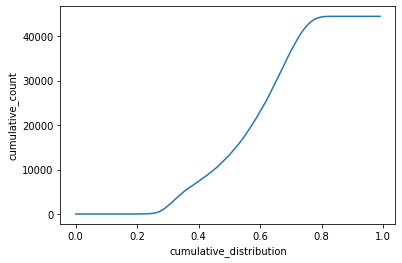

In [ ]:
# توزیع تجمعی مقادیر خروجی بیشینه
import matplotlib.pyplot as plt

cum_values = []
values = []

interval_number = 100
for i in range(0, 100):
    cum_values.append(np.where(val_softmax_values < ((i+1) / interval_number))[0].shape[0])
    values.append(np.where(((i / interval_number) < val_softmax_values) & (val_softmax_values < ((i+1) / interval_number)))[0].shape[0])

# Create a figure and an axis
fig, ax = plt.subplots()

x = np.array(range(0, 100)) / interval_number
ax.plot(x, cum_values)

plt.xlabel('cumulative_distribution')
plt.ylabel('cumulative_count')

# plt.savefig('output_cumulative_distribution.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
false_count = 0
true_count = 0
false_values = []
true_values = []
for i in range(len(testx)):
    if val_softmax_classes[i] != i // 5:
        false_count += 1
        false_values.append(val_softmax_values[i])
    else:
        true_count += 1
        true_values.append(val_softmax_values[i])

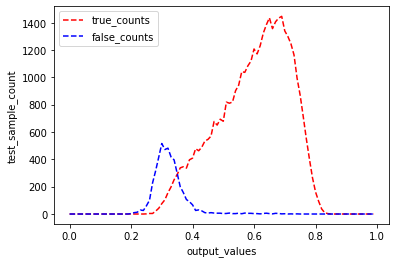

In [ ]:
# توزیع مقادیر خروجی بیشینه صحیح
import matplotlib.pyplot as plt

t_values = []
f_values = []

interval_number = 100
for i in range(0, 100):
    t_values.append(np.where(((i / interval_number) < np.array(true_values)) & (np.array(true_values) < ((i+1) / interval_number)))[0].shape[0])
    f_values.append(np.where(((i / interval_number) < np.array(false_values)) & (np.array(false_values) < ((i+1) / interval_number)))[0].shape[0])

# Create a figure and an axis
fig, ax = plt.subplots()

# Plot the data
x = np.array(range(0, 100)) / interval_number
ax.plot(x, t_values, 'r--', x, f_values, 'b--')

plt.legend(['true_counts', 'false_counts'])

plt.xlabel('output_values')
plt.ylabel('test_sample_count')

# plt.savefig('max_max_output_distribution.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


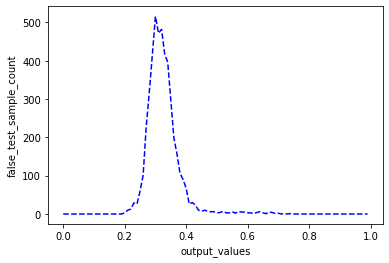

In [ ]:
# Create a figure and an axis
fig, ax = plt.subplots()

# Plot the data
x = np.array(range(0, 100)) / interval_number
ax.plot(x, f_values, 'b--')

plt.xlabel('output_values')
plt.ylabel('false_test_sample_count')

plt.savefig('false_max_max_output_distribution.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
with np.errstate(divide='ignore', invalid='ignore'):
    f_percent = (np.array(f_values) / np.array(values))
    t_percent = (np.array(t_values) / np.array(values))
len(f_values), len(values)

(100, 100)

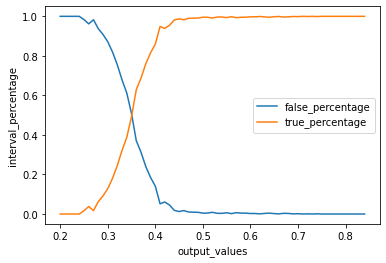

In [ ]:
# توزیع مقادیر خروجی بیشینه غلط
import matplotlib.pyplot as plt

# f_p = []
# interval_number = 100
# for i in range(0, 100):
#     f_p.append(np.where(((i / interval_number) < np.array(f_percent)) & (np.array(f_percent) < ((i+1) / interval_number)))[0].shape[0])

# Create a figure and an axis
fig, ax = plt.subplots()

x = np.array(range(0, 100)) / interval_number
ax.plot(x, f_percent, x, t_percent)

plt.legend(['false_percentage', 'true_percentage'])

plt.xlabel('output_values')
plt.ylabel('interval_percentage')

# plt.savefig('percent_max_max_output_distribution.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
np.where(f_percent == 0)

(array([71, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84], dtype=int64),)

In [ ]:
np.where(np.array(f_values) > 0)[0]

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       72, 74], dtype=int64)

In [ ]:
np.where(np.array(t_values) > 0)

(array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
        42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
        59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
        76, 77, 78, 79, 80, 81, 82, 83, 84], dtype=int64),)

In [ ]:
f_values

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 10,
 13,
 29,
 26,
 60,
 101,
 228,
 317,
 416,
 516,
 472,
 482,
 418,
 396,
 298,
 199,
 157,
 106,
 90,
 67,
 26,
 30,
 23,
 10,
 7,
 10,
 7,
 6,
 6,
 3,
 4,
 7,
 3,
 3,
 6,
 2,
 7,
 5,
 5,
 3,
 3,
 1,
 4,
 6,
 3,
 1,
 5,
 4,
 1,
 2,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
t_values

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 4,
 4,
 21,
 42,
 76,
 104,
 156,
 198,
 251,
 289,
 338,
 346,
 336,
 397,
 409,
 478,
 463,
 489,
 534,
 546,
 570,
 677,
 651,
 694,
 679,
 819,
 811,
 820,
 903,
 943,
 1042,
 1037,
 1085,
 1119,
 1208,
 1172,
 1232,
 1323,
 1385,
 1436,
 1357,
 1407,
 1434,
 1447,
 1340,
 1300,
 1246,
 1165,
 994,
 870,
 714,
 552,
 405,
 267,
 162,
 94,
 37,
 9,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
f_values = np.array(f_values)
for i in range(100):
    if (np.sum(f_values[:i]) > (np.sum(f_values) * 0.98)):
        print(i / 100)
        break

0.48


In [2]:
import glob
import cv2
import pandas as pd
import pathlib


In [3]:
def read_qr_code(filename):
    """Read an image and read the QR code.
    
    Args:
        filename (string): Path to file
    
    Returns:
        qr (string): Value from QR code
    """
    
    try:
        img = cv2.imread(filename)
        detect = cv2.QRCodeDetector()
        value, points, straight_qrcode = detect.detectAndDecode(img)
        return value
    except:
        return


In [4]:
value = read_qr_code('C:/users/dianat/desktop/B0000003.jpg')

In [9]:
# from qrtools import QR
! pip install pypng
! pip install zbar
! pip install pillow

     -------------------------------------- 58.1/58.1 kB 339.1 kB/s eta 0:00:00


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for zbar
Failed to build zbar
  Running setup.py install for zbar: started
  Running setup.py install for zbar: finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [3 lines of output]
      decoder.c
      C:\Users\Dianat\AppData\Local\Temp\pip-install-rjbs3xla\zbar_779643bca9ec4fa28e81afa9c779a8e2\zbarmodule.h(26): fatal error C1083: Cannot open include file: 'zbar.h': No such file or directory
      error: command 'C:\\Program Files (x86)\\Microsoft Visual Studio\\2019\\Enterprise\\VC\\Tools\\MSVC\\14.29.30133\\bin\\HostX86\\x64\\cl.exe' failed with exit code 2
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for zbar
  error: subprocess-exited-with-error
  
  × Running setup.py install for zbar did not run successfully.
  │ exit code: 1
  ╰─> [5 lines of output]
      C:\Users\Dianat\miniconda3\envs\arcface-tf2\lib\site-packages\setuptools\command\install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use buil

In [ ]:
from qrtools import QR
my_QR = QR(filename = "C:/users/dianat/desktop/B0000003.jpg")
  
# decodes the QR code and returns True if successful
my_QR.decode()
  
# prints the data
print (my_QR.data)
